## Import Libraries and initialize other values

In [2]:
# import libraries
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
import datetime
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, f1_score, confusion_matrix, recall_score, 
                             precision_score, roc_curve, roc_auc_score)

In [3]:
# set pandas parameters
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Section 1: Business understanding

In this notebook, we will study a publicly available data set from UCI’s Machine Learning repository (source: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing) to understand the factors that can help determine consumers’ probability of positive response to a Fixed Deposit (FD) marketing campaign. The data is from a campaign run by a Portuguese bank on getting new FDs from existing customers. It has various features on each customer along with a decision variable which indicates where he/she decided to place a FD during the campaign (a positive response)

### We shall attempt to answer the below questions:
Q1. Here we shall try to ascertain whether engagement levels with consumers prior to a campaign determine success in a new campaign.

Q2. Does the success from a previous campaign determine success in a new campaign?

Q3. Does External benchmark affect success?

# Section 2: Data understanding

## Import and clean data

In [5]:
# set paths
directory_path = 'bank-additional'
file_name = 'bank-additional-full.csv'

In [6]:
# import data
df_raw = pd.read_csv(file_name, sep = ';',
                     dtype = {'y' : 'category'})

# view shape
df_raw.shape

(41188, 21)

In [7]:
# encode target variable as 0 and 1
df_raw['y'] = df_raw['y'].cat.codes

In [8]:
# view sample rows
df_raw.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [9]:
# view column details
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null int8
dtypes: float64(5), int64(5), int8(1), object(10)
mem

In [10]:
# view basic columns details
df_raw.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


#### Analyze various columns

In [11]:
df_raw.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [12]:
df_raw['job'].value_counts() # missing values - medium

admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64

In [13]:
df_raw['marital'].value_counts() # missing values - low

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64

In [14]:
df_raw['education'].value_counts() # missing values - low

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [15]:
df_raw['default'].value_counts() # missing values - low

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

In [16]:
df_raw['housing'].value_counts() # missing values - low

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [17]:
df_raw['loan'].value_counts() # missing values - low

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64

In [18]:
df_raw['contact'].value_counts() # missing values - nil

cellular     26144
telephone    15044
Name: contact, dtype: int64

In [19]:
df_raw['month'].value_counts() # missing values - nil

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

In [20]:
df_raw['day_of_week'].value_counts() # missing values - nil

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64

In [21]:
df_raw['poutcome'].value_counts() # very high value of non-existent

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64

In [22]:
df_raw['y'].value_counts() # missing valies - nil

0    36548
1     4640
Name: y, dtype: int64

# Section 3 and 4: Data Preparation and evaluation

Some data preparation steps (such as missing value treatment for some fields) has been done in a single step, whereas for others i.e. for the respective questions being answered, the data preparation is done under the section for that questions

The evaluation is done after the visualization step with each questions' section

#### Replace missing values

There are certain columns which have missing values tagged as 'Unknown'. For each of the respective fields, we shall replace these missing values as per the context of the field. We shall use pandas' replace method for the same

In [23]:
# replace missing values for each column

df_raw.replace(to_replace = 'unknown', 
               value = {'job' : 'unemployed',
                        'marital' : 'single',
                        'education' : 'illiterate',
                        'default' : 'no',
                        'housing' : 'no',
                        'loan' : 'no'},
              inplace = True)

#### Function to create bar plot

Below we create a function that will create bar plot with the inputs provided. We shall be using the function in our analysis

In [26]:
### define function to create bar plots
def create_bar_plot(df, x, y, xlabel, ylabel, figsize):
    '''
    Function to create a barplot with provided inputs
    
    Parameters
    -----------
    
    df: Pandas dataframe
    Dataframe using which the plot shall be created
    
    x: str
    df column name whose values shall be plotted on the x-axis
    
    y: str
    df column name whose values shall be plotted on the y-axis
    
    xlabel: str
    Label of x-axis
    
    ylabel: str
    Label of y-axis
    
    figsize: tuple
    Size of the desired plot
    '''
    
    plt.figure(figsize = figsize)
    sns.barplot(data = df, x = x, y = y, color = 'cyan', ci = None)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Q1. Here we shall try to ascertain whether engagement levels with consumers prior to a campaign determine success in a new campaign.

### 1.1 We shall attemp to answer this using the association of 'previous' with the response variable (y). 'previous' variable depicts the number of contacts performed before this campaign and for this client

In [28]:
df_raw['previous'].mean()

0.17296299893172767

In [29]:
df_raw['previous'].value_counts()

0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: previous, dtype: int64

#### Data Prepartion
Divide the 'previous' column into bins using pandas' cut function and provide relevant labels

In [30]:
df_raw['previous_bin'] = pd.cut(x = df_raw['previous'], 
                                bins = [0, 1, 3, 6, df_raw['previous'].max()],
                                right = False,
                                labels = ['No contact', '1-2', '3-5', '>5']
                               )

In [31]:
df_raw.groupby(by = 'previous_bin')['y'].mean()

previous_bin
No contact    0.088322
1-2           0.247789
3-5           0.588816
>5            0.600000
Name: y, dtype: float64

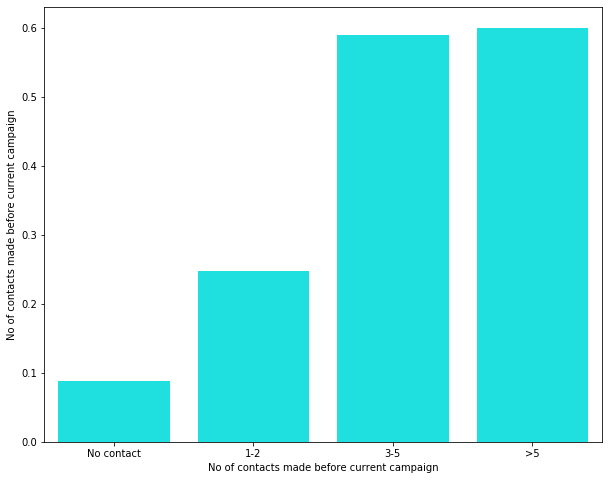

In [32]:
create_bar_plot(df = df_raw, x = 'previous_bin', y = 'y', 
                xlabel = 'No of contacts made before current campaign',
                ylabel = 'No of contacts made before current campaign',
                figsize = (10, 8))

#### Evaluation: 
Figure above clearly shows that higher number of connects with consumers prior to a new campaign lead to a better conversion rate in a new campaign. Consumers with 3–5 or >5 connects had the highest conversion rate of close to 60% as against consumers which had not been contacted previously or were contacted less than thrice

### 1.2 Here, we look at the recency of the last connect with consumers to determine success. We shall look at association between 'y' and 'pdays' which represents number of days that passed by after the client was last contacted from a previous campaign

In [34]:
df_raw.replace({'pdays': {999 : -1}}, inplace = True)

#### Data Prepartion
Divide the 'pdays' column into bins using pandas' cut function and provide relevant labels

In [35]:
df_raw['pdays_bin'] = pd.cut(x = df_raw['pdays'], 
                             bins = [-1, 0, 2, 5, 11, df_raw['pdays'].max()],
                             right = False,
                             labels = ['Not contact', '0-1', '2-4', '5-10', '>10']
                            )

In [36]:
df_raw.groupby(by = 'pdays_bin')['y'].mean()

pdays_bin
Not contact    0.092582
0-1            0.439024
2-4            0.644013
5-10           0.667178
>10            0.566502
Name: y, dtype: float64

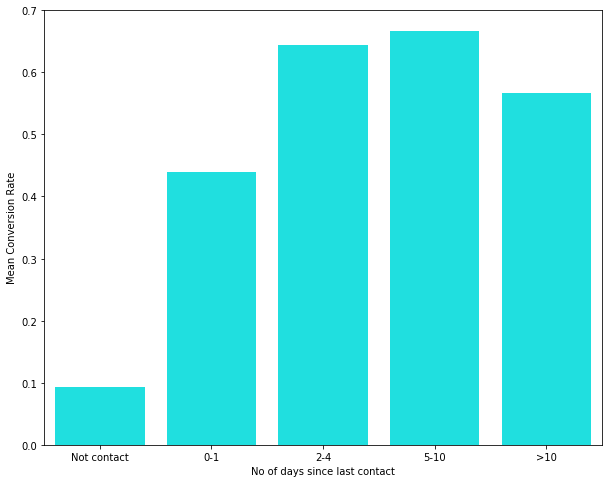

In [37]:
create_bar_plot(df = df_raw, x = 'pdays_bin', y = 'y', 
                xlabel = 'No of days since last contact',
                ylabel = 'Mean Conversion Rate',
                figsize = (10, 8))

#### Evaluation: 
Consumers which have not been contacted have the least success rate. Clients which have been very recently contacted don't necessarily respond best towards a new campaign, as evidenced by the second lowest success rate of 0–1 days category. Where the contact was made 2–10 days had the highest chance of success. As the last contact goes beyond 10 days, we see a dip in the success rate.

##  Q2. Does the success from a previous campaign determine success in a new campaign?

### We study association of 'y' with 'putcome' which signals success in a previous campaign

In [38]:
df_raw.groupby(by = 'poutcome')['y'].mean()

poutcome
failure        0.142286
nonexistent    0.088322
success        0.651129
Name: y, dtype: float64

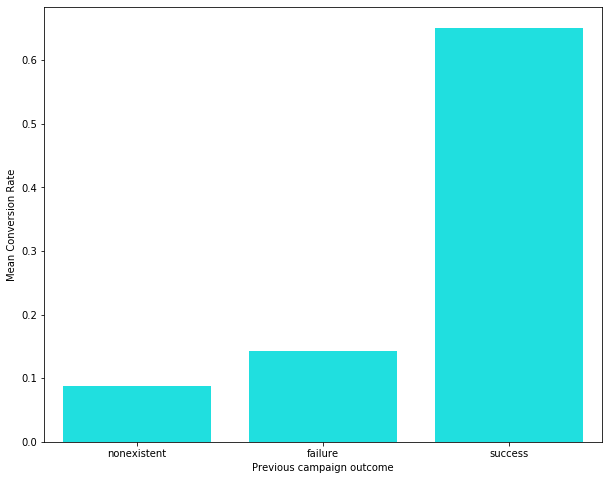

In [39]:
create_bar_plot(df = df_raw, x = 'poutcome', y = 'y', 
                xlabel = 'Previous campaign outcome',
                ylabel = 'Mean Conversion Rate',
                figsize = (10, 8))

#### Evaluation: 
Figure above probably justifies the experiential wisdom of bankers which is to market to consumers where they experienced success perviously. Success rate on new campaigns is significantly higher for clients who also responded positively to a prior campaign.

##  Q3. Does External benchmark affect success?

### We shall study movement of an external benchmark (3M Euribor) and conversion rate (y) across various months

#### Data Prepartion
Create a new column 'month_enoded' by converting the month values into respective numbers i.e. 1 for Jan, 2 for Feb etc.

In [169]:
df_raw['month_encoded'] = [datetime.datetime.strptime(d, '%b').month for d in df_raw['month']]

Text(0, 0.5, '3M Euribor')

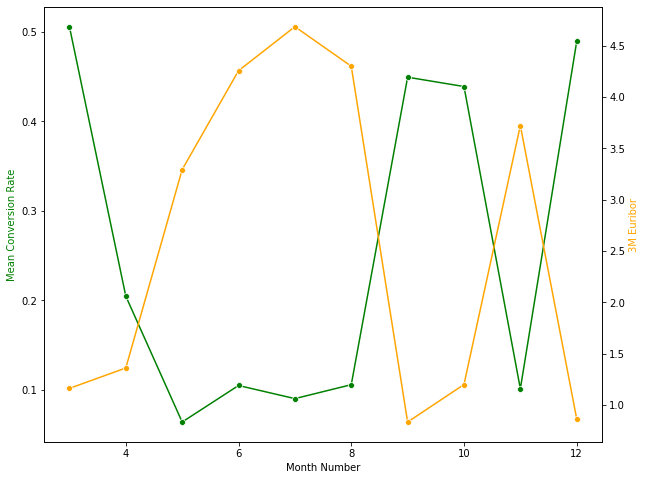

In [170]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.lineplot(data = df_raw, x = 'month_encoded', y = 'y', color = 'green', ci = None, marker = 'o')
plt.xlabel('Month Number')
plt.ylabel('Mean Conversion Rate', color = 'green')

ax2 = ax.twinx()
sns.lineplot(data = df_raw, x = 'month_encoded', y = 'euribor3m', color = 'orange', ci = None, marker = 'o')
plt.ylabel('3M Euribor', color = 'orange')

#### Evaluation: 
The above chart plots movements of 3M Euribor (an external rate benchmark) and conversion rate across months when the campaign was run in the data. We see an inverse relationship between the 2 metrics i.e. with increase in the external benchmark, the success rate falls and vice versa. The above seems to be counter-intuitive from a business sense as consumers should, ideally, be placing more bank FDs as rates increase. One reason of these negative relationship could be that the bank (being studied in the data set) may be slow in passing on the market rate changes to its consumers.

## Section below is in addition to the 3 main questions we try to answer. Below section attempts to create a predictive model prediction of 'y' using all the predictor fields in the data

#### Split data into training and test set

In [174]:
# create stratified shuffle split object
sss = StratifiedShuffleSplit(n_splits = 2, test_size = 0.2, random_state = 42)

In [175]:
# reset index
df_raw.reset_index(inplace = True, drop = True)

# split between train and test dfs
for train_indices, test_indices in sss.split(df_raw, df_raw['y']):
    df_train = df_raw.loc[train_indices]
    df_test = df_raw.loc[test_indices]

print('Train data shape:', df_train.shape)
print('Test data shape:', df_test.shape)

Train data shape: (32950, 25)
Test data shape: (8238, 25)


In [176]:
print('Incidence rate in total data :', df_raw['y'].sum() / df_raw.shape[0])
print('Incidence rate in training data :', df_train['y'].sum() / df_train.shape[0])
print('Incidence rate in test data :', df_test['y'].sum() / df_test.shape[0])

Incidence rate in total data : 0.11265417111780131
Incidence rate in training data : 0.11265553869499241
Incidence rate in test data : 0.11264870114105366


#### Create pipeline for data transformation

In [177]:
df_raw.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,previous_bin,pdays_bin,month_encoded,euribor_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No contact,Not contact,5,"(3.0, 7.0]"
1,57,services,married,high.school,no,no,no,telephone,may,mon,149,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No contact,Not contact,5,"(3.0, 7.0]"
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No contact,Not contact,5,"(3.0, 7.0]"
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No contact,Not contact,5,"(3.0, 7.0]"
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,No contact,Not contact,5,"(3.0, 7.0]"


In [4]:
# create transformer for yes/no columns
class encode_categorical_cols(BaseEstimator, TransformerMixin):
    '''
    Function to encode categorical columns by converting into multiple columns. 
    Number of new columns = Number of categories - 1
    '''
    
    def __init__(self):
        return None
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        X = pd.get_dummies(X, prefix = X.columns, prefix_sep = '_', drop_first = True, sparse = False)
        self.categories_ = X.columns
        return X

In [179]:
# define numeric cols
num_cols = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
            'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

In [180]:
# define categorical cols
cat_cols = ['job', 'marital', 'education', 'default', 'housing', 
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [181]:
# column transformer for standard scaler and one hot encoding
full_pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', encode_categorical_cols(), cat_cols)
], remainder = 'drop')

In [182]:
## create X and y sets for training and testing data
# training data
X_train = full_pipeline.fit_transform(df_train)
y_train = df_train['y']

# testing data
X_test = full_pipeline.transform(df_test)
y_test = df_test['y']

In [183]:
# create list of variables
cat_encoder = full_pipeline.named_transformers_['cat']
cat_attribs = cat_encoder.categories_.tolist()

attributes = num_cols + cat_attribs

### Try different models

#### Logistic Regression

In [184]:
# initialize model object
log_mod = LogisticRegression(n_jobs = -1, 
                             solver = 'lbfgs', 
                             max_iter = 500)

In [185]:
# fit training data
log_mod.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [186]:
# view accuracy on training and test data
print('Training data accuracy:', accuracy_score(y_train, log_mod.predict(X_train)))
print('Test data accuracy:', accuracy_score(y_test, log_mod.predict(X_test)))

# view precision and recall on test data
print('Test Data Precision:', precision_score(y_test, log_mod.predict(X_test)))
print('Test Data Recall:', recall_score(y_test, log_mod.predict(X_test)))

Training data accuracy: 0.9097723823975721
Test data accuracy: 0.9170915270696771
Test Data Precision: 0.7231329690346083
Test Data Recall: 0.42780172413793105


In [187]:
# view confusion matrix on test data
confusion_matrix(y_test, log_mod.predict(X_test)) # actuals in rows

array([[7158,  152],
       [ 531,  397]])

#### Random Forest

In [188]:
# initialize model object
rf_mod = RandomForestClassifier()

# create grid search object
param_grid_rf = {'n_estimators' : [150],
                 'criterion' : ['gini', 'entropy'],
                 'max_depth' : [25, 50, 75],
                 'min_samples_leaf' : [15, 20, 50]}

# create grid search object
grid_rf = GridSearchCV(rf_mod, param_grid = param_grid_rf, n_jobs = -1, 
                       scoring = 'accuracy', cv = 3,  verbose = 2)

In [189]:
# fit training data
grid_rf.fit(X_train, y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:   37.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [190]:
# view best params
grid_rf.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 15,
 'n_estimators': 150}

In [191]:
# save the best model
rf_best = grid_rf.best_estimator_

In [192]:
# view accuracy on training and test data
print('Training data accuracy:', accuracy_score(y_train, rf_best.predict(X_train)))
print('Test data accuracy:', accuracy_score(y_test, rf_best.predict(X_test)))

# view precision and recall on test data
print('Test Data Precision:', precision_score(y_test, rf_best.predict(X_test)))
print('Test Data Recall:', recall_score(y_test, rf_best.predict(X_test)))

Training data accuracy: 0.923763277693475
Test data accuracy: 0.9124787569798495
Test Data Precision: 0.7368421052631579
Test Data Recall: 0.34698275862068967


In [193]:
# view confusion matrix on test data
confusion_matrix(y_test, rf_best.predict(X_test)) # actuals in rows

array([[7195,  115],
       [ 606,  322]])

In [194]:
# view feature importances
sorted(zip(rf_best.feature_importances_, attributes), reverse = True)

[(0.39364965758233567, 'duration'),
 (0.11346068089281618, 'nr.employed'),
 (0.10223591498138843, 'euribor3m'),
 (0.06386407469495291, 'pdays'),
 (0.04879906363190426, 'cons.conf.idx'),
 (0.04842717733387818, 'poutcome_success'),
 (0.04410264153422152, 'emp.var.rate'),
 (0.034502805402922825, 'cons.price.idx'),
 (0.027166420913764432, 'age'),
 (0.01336108324955852, 'previous'),
 (0.009651036295322223, 'contact_telephone'),
 (0.009403258926486618, 'campaign'),
 (0.008876125722312828, 'poutcome_nonexistent'),
 (0.008163306355700305, 'month_may'),
 (0.008095914096026353, 'month_oct'),
 (0.007388912054482904, 'month_mar'),
 (0.004849194469271724, 'education_university.degree'),
 (0.004820039285507484, 'day_of_week_mon'),
 (0.004064099256787087, 'day_of_week_thu'),
 (0.0038668912075754246, 'housing_yes'),
 (0.003565886876889767, 'marital_married'),
 (0.0033603183743017287, 'marital_single'),
 (0.002743369183449754, 'day_of_week_tue'),
 (0.0026551242401500466, 'job_blue-collar'),
 (0.0026319

#### GBM

In [195]:
# initialize model object
gbm_mod = GradientBoostingClassifier()

# create grid search object
param_grid_gbm = {'n_estimators' : [100, 500],
                 'learning_rate' : [0.01, 0.1],
                 'max_depth' : [1, 3, 5, 10],
                 'subsample' : [0.5, 1]}

# create grid search object
grid_gbm = GridSearchCV(gbm_mod, param_grid = param_grid_gbm, n_jobs = -1, 
                       scoring = 'accuracy', cv = 3,  verbose = 2)

In [196]:
# fit training data
grid_gbm.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed: 18.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [197]:
# view best params
grid_gbm.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500, 'subsample': 0.5}

In [198]:
# save the best model
gbm_best = grid_gbm.best_estimator_

In [199]:
# view accuracy on training and test data
print('Training data accuracy:', accuracy_score(y_train, gbm_best.predict(X_train)))
print('Test data accuracy:', accuracy_score(y_test, gbm_best.predict(X_test)))

# view precision and recall on test data
print('Test Data Precision:', precision_score(y_test, gbm_best.predict(X_test)))
print('Test Data Recall:', recall_score(y_test, gbm_best.predict(X_test)))

Training data accuracy: 0.9293474962063732
Test data accuracy: 0.9201262442340374
Test Data Precision: 0.6880222841225627
Test Data Recall: 0.5323275862068966


In [200]:
# view confusion matrix on test data
confusion_matrix(y_test, gbm_best.predict(X_test)) # actuals in rows

array([[7086,  224],
       [ 434,  494]])

In [201]:
# view feature importances
# sorted(zip(gbm_best.feature_importances_, attributes), reverse = True)

#### XG Boost

In [202]:
# define imbalance ratio
imbalance_ratio = (y_train.count() - y_train.sum()) / y_train.sum()

# initialize model object
xgb_mod = xgboost.XGBClassifier(objective = 'binary:logistic',
                                scale_pos_weight = imbalance_ratio
                               )

# create grid search object
param_grid_xgb = {'n_estimators' : [200],
                  'learning_rate' : [0.01, 0.1],
                  'max_depth' : [5, 10, 25],
                  'subsample' : [0.25, 0.5, 1],
                  'colsample_bytree' : [1],
                  'colsample_bylevel' : [0.5, 1],}

# # create grid search object
grid_xgb = GridSearchCV(xgb_mod, param_grid = param_grid_xgb, n_jobs = -1, 
                        scoring = 'accuracy', cv = 5,  verbose = 2)

In [ ]:
# fit training data
grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.1min


In [ ]:
# view best params
grid_xgb.best_params_

In [ ]:
# save the best model
xgb_best = grid_xgb.best_estimator_

In [ ]:
# view accuracy on training and test data
print('Training data accuracy:', accuracy_score(y_train, xgb_best.predict(X_train)))
print('Test data accuracy:', accuracy_score(y_test, xgb_best.predict(X_test)))

# view precision and recall on test data
print('Test Data Precision:', precision_score(y_test, xgb_best.predict(X_test)))
print('Test Data Recall:', recall_score(y_test, xgb_best.predict(X_test)))

In [ ]:
# view confusion matrix on test data
confusion_matrix(y_test, xgb_best.predict(X_test)) # actuals in rows